# Testing the WordCloud library

I've chosen to use this library because there is no need to re-invent the wheel. Most naive implementations using bare matplotlib have superimposed words.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import io
from collections import Counter
from wordcloud import WordCloud
import numpy as np

In [25]:
# Let's grab a csv generated by twitterGeoLoc.py
# To reproduce you may need to change this filename
df = pd.read_csv('OutputStreaming_20191026-153306.csv')

In [21]:
def get_word_frequency(dataframe, wordlist):
    """
    Count how many tweets contain a given word
    :param dataframe: Pandas dataframe from the tweepy mining
    :param wordlist: array-like with the keywords
    
    TODO: - drop dependency on numpy?
    """
    word_freq = dict()
    for word in wordlist:
        word_freq[word] = np.where(df['text'].str.contains(word))[0].size
    
    return word_freq

In [22]:
wordlist = io.open('kw.csv').read()
wordlist = wordlist.split(', ')
wf = get_word_frequency(df, wordlist)

Vanilla example of WordCloud functionality

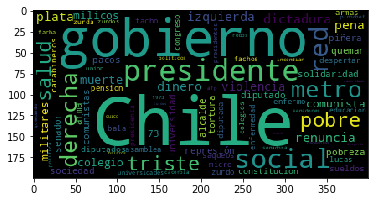

In [24]:
word_cloud = WordCloud().generate_from_frequencies(wf)
plt.imshow(word_cloud)

Now let's make this bigger and with nicer colors

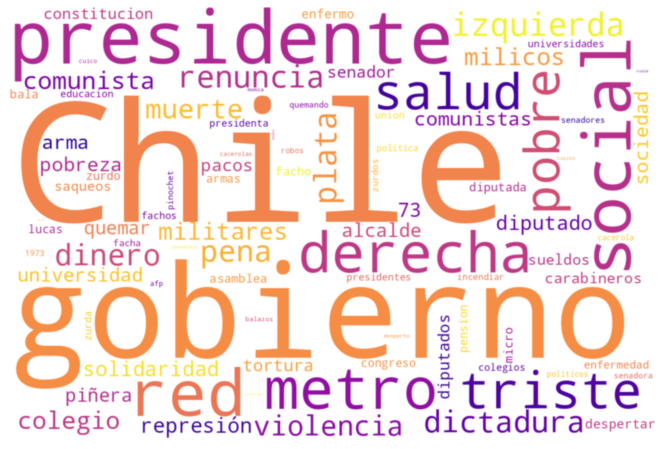

In [32]:
word_cloud = WordCloud(background_color='white', colormap='plasma', width= 1200, height=800).generate_from_frequencies(wf)
fig, ax = plt.subplots(figsize=(12,8))
ax.axis('off')
ax.imshow(word_cloud, interpolation='bicubic');